In [5]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import os

#set device
device = torch.device("cpu")

#load in alexnet
alexnet = models.alexnet(pretrained=True).to(device)
alexnet.eval()

#image transforms
transform = transforms.Compose([
    transforms.Resize(256),         
    transforms.CenterCrop(224),     
    transforms.ToTensor(),          
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

#function to extract features from a layer
def getLayerOutput(layer, x):
    outputs = []
    def forwardHook(module, input, output):
        outputs.append(output)
    hook = layer.register_forward_hook(forwardHook)
    alexnet(x.unsqueeze(0).to(device))
    hook.remove()
    return outputs[0]

#images folder path
imageSetFolder = './Image Set'


#list of images
imagesList = os.listdir(imageSetFolder)

#map layer names
layerMapping = {
    'Conv1': alexnet.features[0], 
    'Conv2': alexnet.features[3],
    'Conv3': alexnet.features[6], 
    'Conv4': alexnet.features[8],
    'Conv5': alexnet.features[10], 
    'fc6': alexnet.classifier[1],
    'fc7': alexnet.classifier[4]
}

#features for each image
features = {layer: [] for layer in layerMapping}
for imgName in imagesList:
    imgPath = os.path.join(imageSetFolder, imgName)
    img = Image.open(imgPath).convert('RGB')
    imgTensor = transform(img)
    
    for layerName, layer in layerMapping.items():
        layer_output = getLayerOutput(layer, imgTensor)
        features[layerName].append(layer_output.cpu().detach().numpy().ravel())




C:\Users\benja\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\benja\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
from scipy.spatial.distance import pdist, squareform

#function for creating rdm
def createRdm(features):
    #find distancematrix and make it square
    distanceMatrix = squareform(pdist(features, 'euclidean'))
    return distanceMatrix

#rdm for each layer
rdms = {layer: createRdm(np.array(features[layer])) for layer in features}


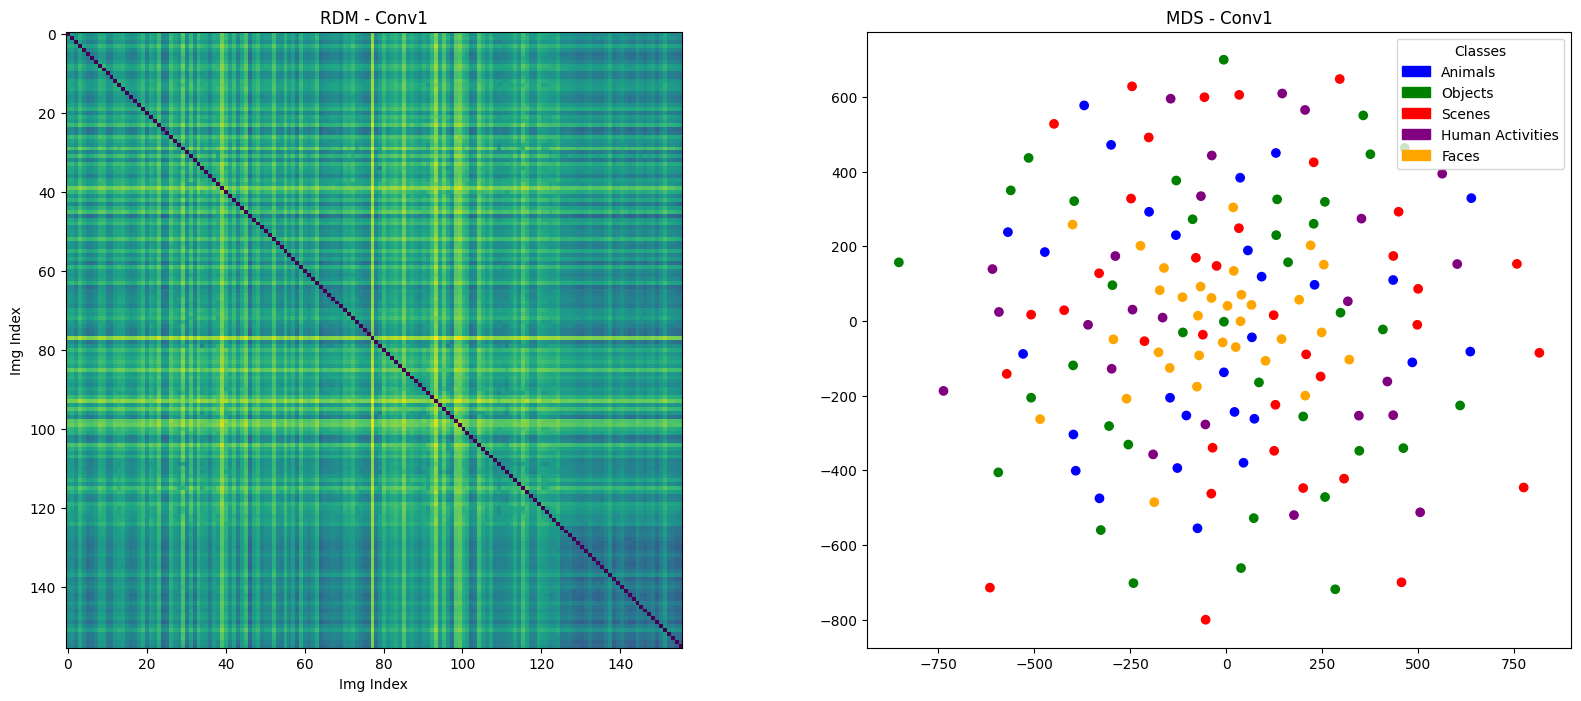

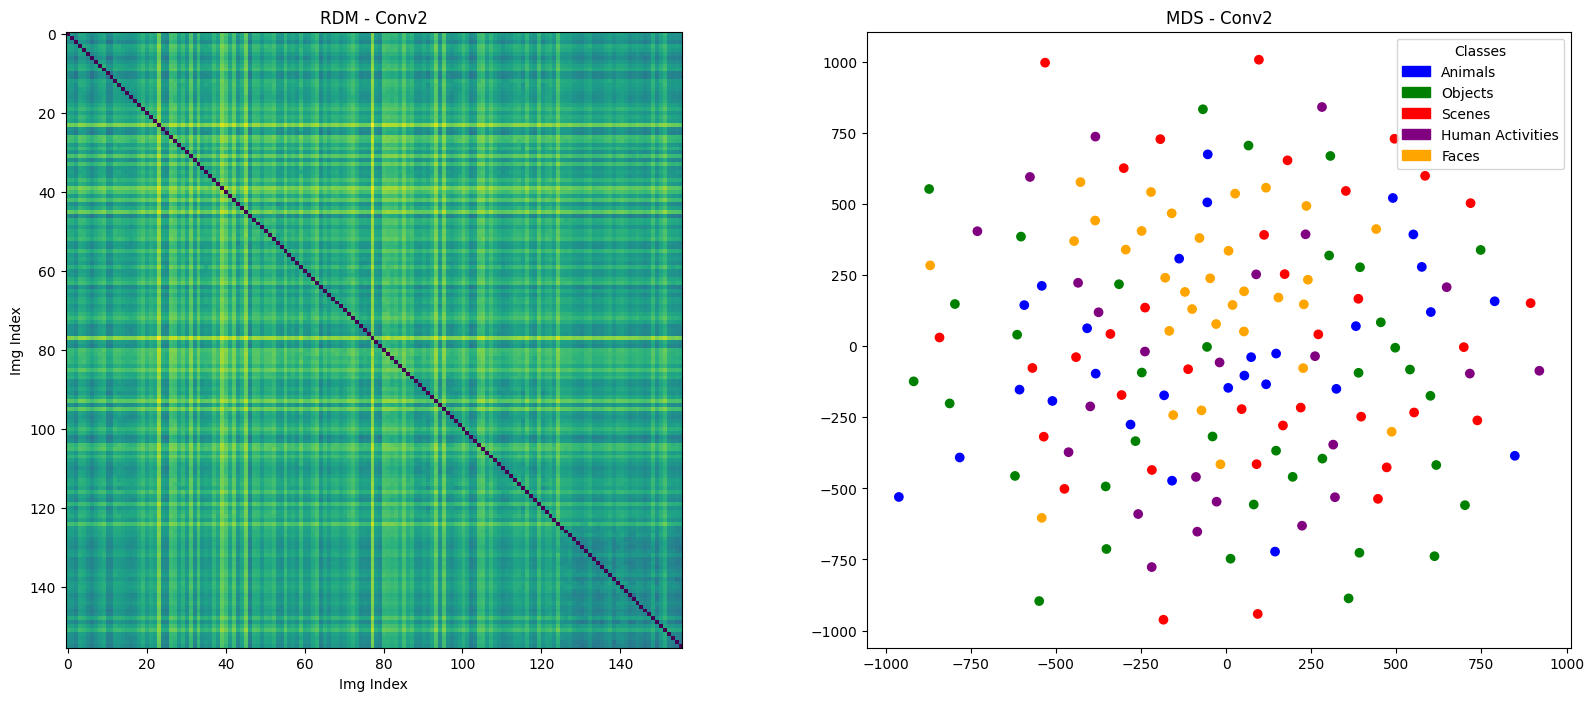

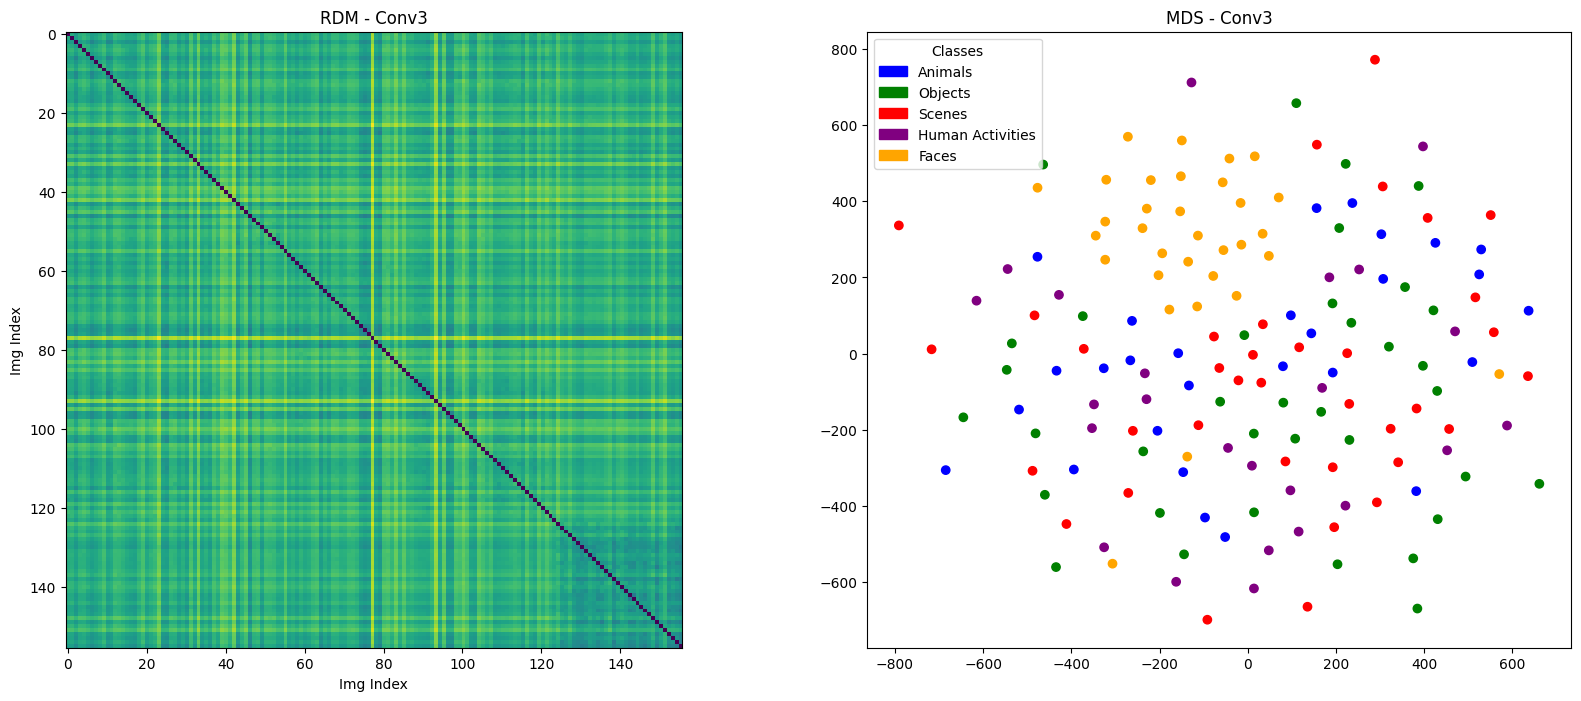

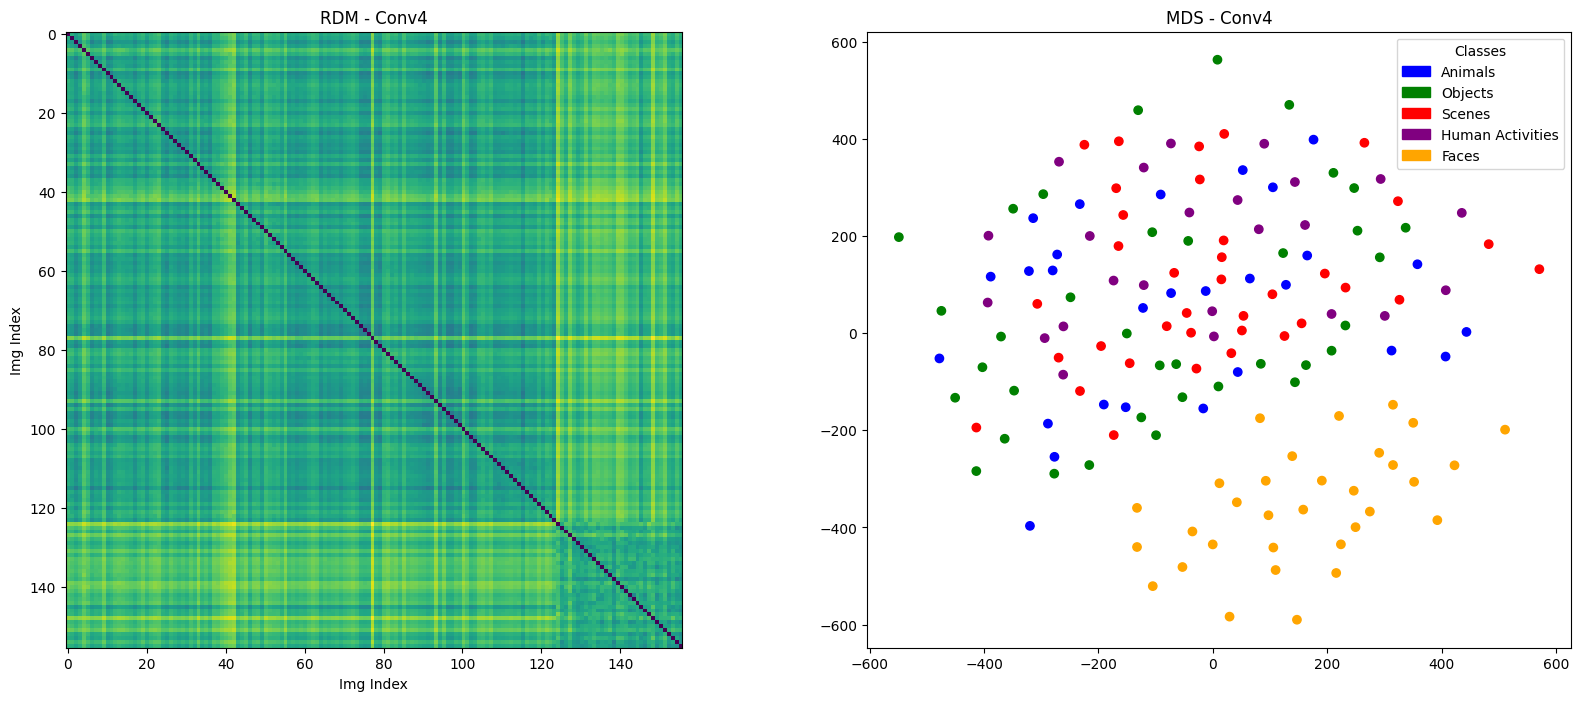

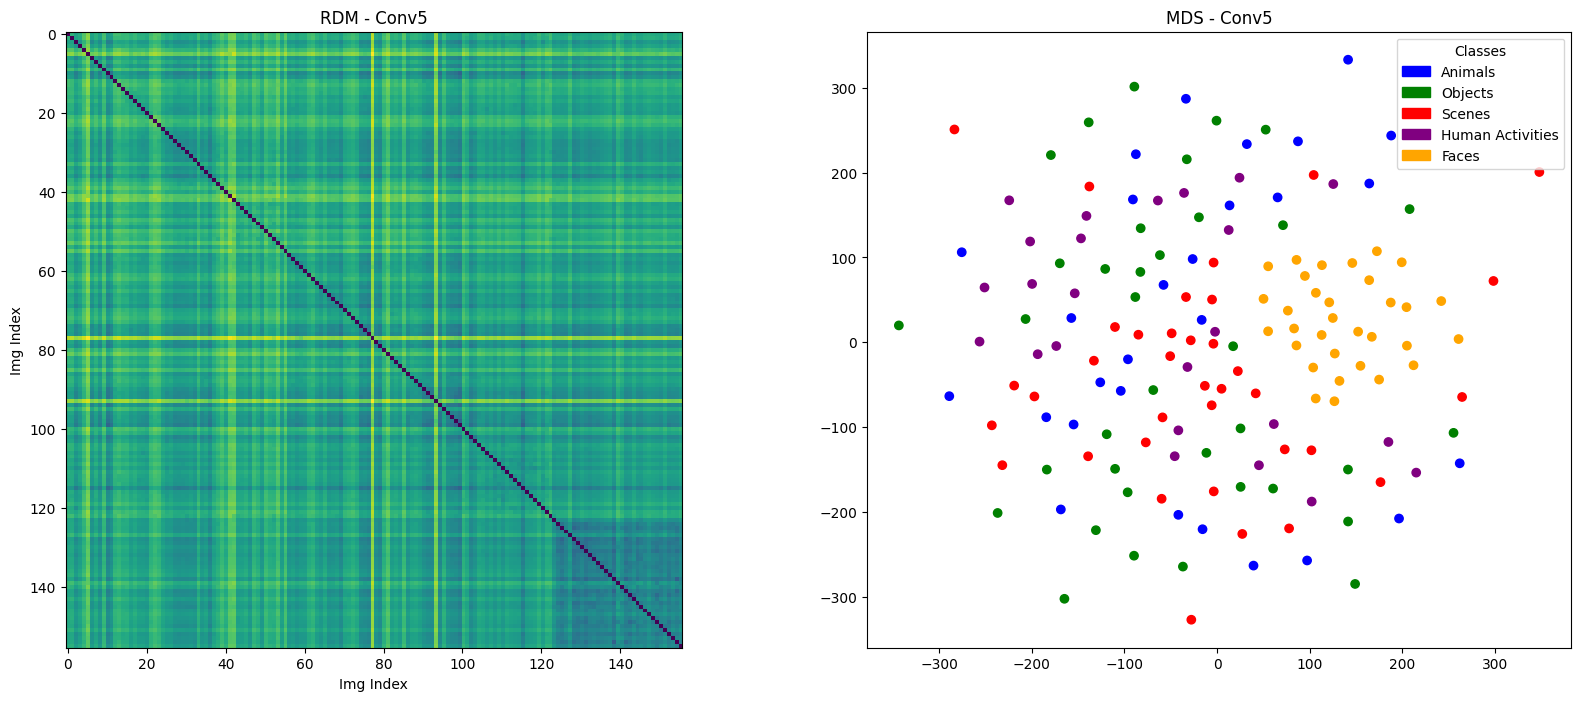

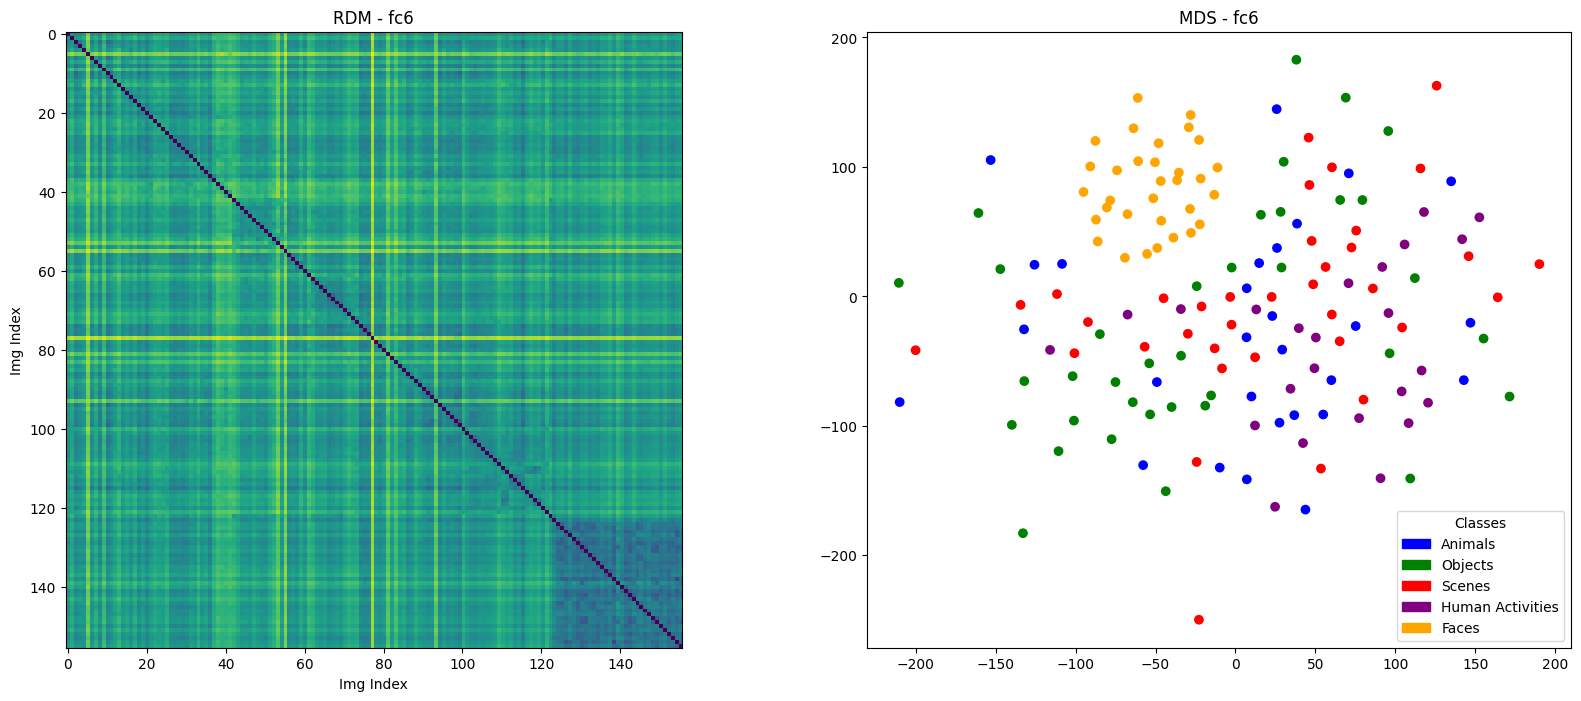

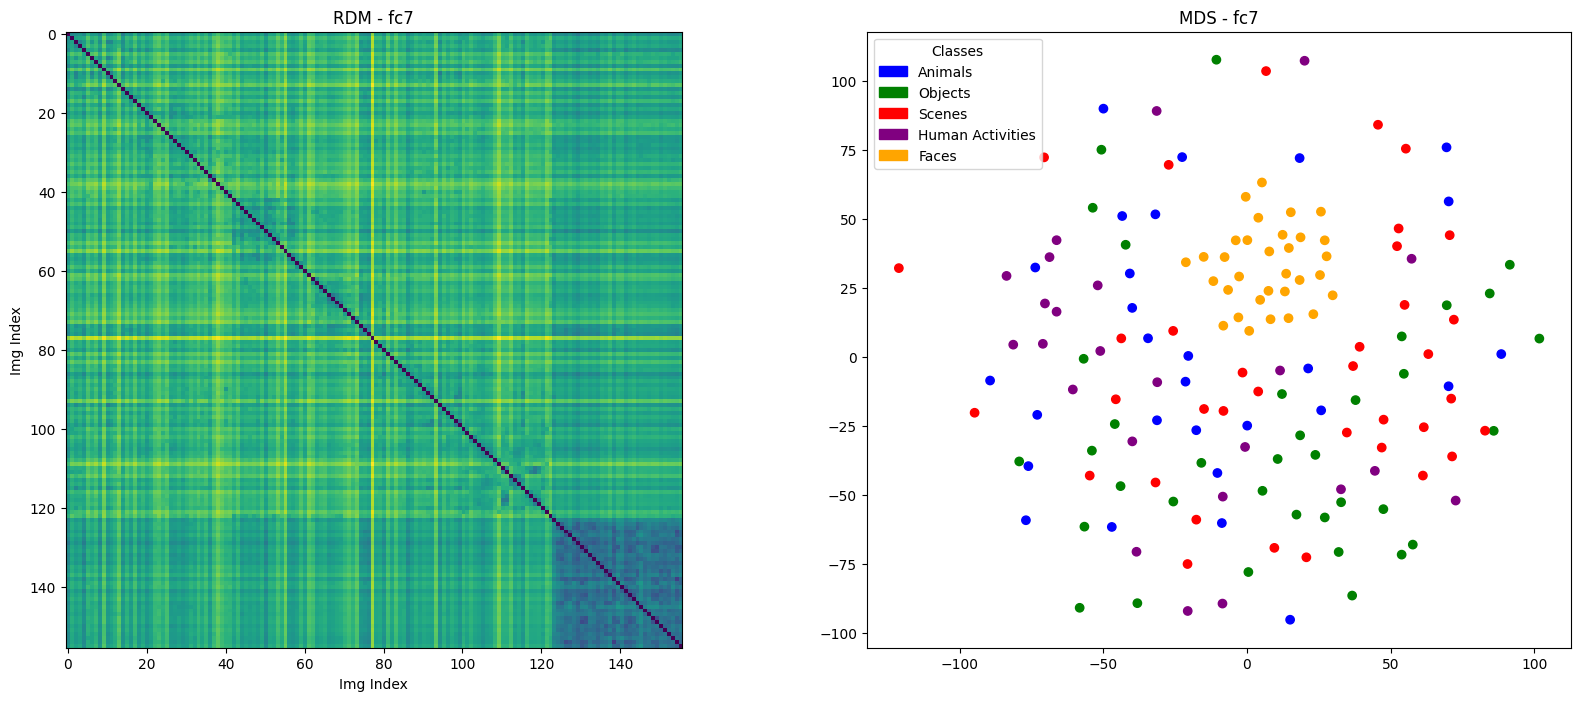

In [7]:
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
import matplotlib.patches as mpatches

#plot rdm and mds beside eachother
def plotRdmMds(matrix, layerName):
    #figure with 2 subplots 
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    #plot rdm
    ax1.imshow(matrix)
    ax1.set_title(f"RDM - {layerName}")
    ax1.set_xlabel("Img Index")
    ax1.set_ylabel("Img Index")

    #mds
    mds = MDS(n_components=2, dissimilarity='precomputed', random_state=0)
    coords = mds.fit_transform(matrix)

    #colours 
    classColours = ['blue', 'green', 'red', 'purple', 'orange']
    colors = [classColours[0]]*28+[classColours[1]]*(64 -28) + [classColours[2]]*(100-64) + [classColours[3]] *(124-100) + [classColours[4]] *(156 - 124)

    # Plot MDS
    ax2.scatter(coords[:, 0], coords[:, 1], c=colors)
    ax2.set_title(f"MDS - {layerName}")

    #custom legend to match labels
    classLabels = ['Animals', 'Objects', 'Scenes', 'Human Activities', 'Faces']
    legend_handles = [mpatches.Patch(color=classColours[i], label=classLabels[i]) for i in range(len(classLabels))]
    ax2.legend(handles=legend_handles, title="Classes")

    plt.show()

#plot rdm and mds
for layer in rdms:
    plotRdmMds(rdms[layer], layer)
